**From the instructions**

Vision: Programming is more than writing code. The ultimate goal of the projects in this course
is that you learn to formulate a programming problem of your own choice, and find your own way
to solve it, and present the results. The bullets below are minimum requirements, but otherwise it is
very much up to you, what you will like to do with your project. I hope to see some creative ideas!

• Objectives: In your model analysis project, you should show that you can:
1. Apply model analysis methods (e.g. scipy.optimize, scipy.linalg, sympy)
2. Structure a code project
3. Document code
4. Present results in text form and in figures

• Content: In your model analysis project, you should at a minimum:
1. Describe an algorithm on how to solve a simple economic model (most likely taken from a textbook)
2. Solve (and perhaps simulate) a simple economic model
3. Visualize results across e.g. parametrizations
4. Analyze one or more extensions of the baseline model

• Structure: Your data analysis project should consist of:
1. A README.md with a short introduction to your project
2. A single self-contained notebook (.ipynb) presenting the analysis
3. (Optionally) Fully documented Python files (.py)
• Size: Quality before quantity.
• Hand-in: On GitHub by uploading it to the folder:
github.com/projects-2019-YOURGROUPNAME/modelproject/
• Deadline: 10th of May 23.59
• Supervision: The exercises class in the weeks starting 29th of April and 6th of May will
give you time to work on your model project and receive supervision from the lecturer and the
teaching assistants. Also, remember the online forum.
• Peer feedback: After handing in, you will be asked to give peer feedback on the projects of
two other groups.
• Exam: Your model analysis project will be a part of your exam portfolio. You are free to
incorporate the peer feedback and other comments before handing in the final version.

#### Imports

In [4]:
#Imports
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


import sympy as sm
import scipy as sp
from scipy import linalg
from scipy import optimize, arange
from scipy import interpolate

import functions

%load_ext autoreload
%autoreload 2

# Introduction - Cournot Competition

## The general setup

$N\geq2$ firms compete in an industry with a homogenous good, where each firm maximises their own profits by choosing a quantity to produce (the production) taking the production from other firms as given.

The inverse aggregate market demand for the homogenous good is assumed to be downwards sloping and linear:
$$
P=\max\{a-bQ,0\}
$$
Where $P$ is the price for the homogenous good and $a,b>0$ are parameters that reflect the demand of consumers. $Q$ is the industry output, defined as the sum of all $N$ individual firms' production:
$$
Q=\sum_{i=1}^N q_i
$$

It can be helpful for notation purposes to define the sum of all other firms' production from the point of view of firm $i$ as:
$$
Q_{-i}=Q-q_i
$$

Firms are not necesarrily homogenous in their costs - rather, firms may have assymmetric marginal costs $c_i>0$ with no capacity constraints. Thus, each firms maximises profit by choosing production level:

$$
\max_{q_i}\pi_i=Pq_i-c_iq_i\Leftrightarrow \max_{q_i}\pi_i=(a-b(Q_{-i}+q_i)-c_iq_i
$$
s.t.
$$
q_i\geq 0
$$
$$
a,b,c_i> 0
$$

Where firms are $i=1,...,N$

This is a classic Industrial Organisation problem, where firms act strategically, taking the actions of other firms into account. 

Specifically, this means that in order to solve model, we must:
- Find the best response function for each individual firm (i.e. what quantity will the firm produce as a function of the other firms' production)
- Find the equilibrium, where all firms have no incentive to deviate - i.e. they are best-responding to each other.

## The simple case - $N=2$

In order to build up our general purpose function, we start off with the simple case, where $N=2$, which means that inverse demand is (using supscripts $i$ and $j$):
$$
P=\max\{a-b(q_i+q_j), 0\}
$$

And the individual firm's maxmisation problem:

$$
\max_{q_i}\pi_i=(a-b(q_i+q_j)-c_iq_i
$$
s.t.
$$
q_i\geq 0
$$
$$
a,b,c_i> 0
$$

### Numerical optimization

First, we define the relevant inverse demand (also called price) function, cost function and profit functions - these functions are symmetric across firms (only input needs to be changed)

In [5]:
def price(q1, q2, a, b): #Overall inverse demand function as a function of all quantities and the relevant parameters
    price = a-b*(q1+q2)
    return price

def cost(q, c): #A cost function for a given firm
    cost = q*c
    return cost

def profit(q1, q2, a, b, c): #Profit for a given firm with production q1 and costs c
    profit = price(q1, q2, a, b)*q1-cost(q1, c)
    return profit

In [6]:
def best_response(q2, c1, a, b): #best response for firm 1 - found by maximising profits taking q2 as given
    q1 =  optimize.fminbound(lambda x: -profit(x, q2, a, b, c1), # minimizing minus profits
                             0, #lower bound is zero
                             a, #upper bound is a (should maybe include a-b*x ?)
                             full_output=True,
                            disp=True)
    return q1[0]


We now have a given firms best response to any level of production from the other firm, given the firms' own costs - let's see isolated examples for firm 1:

In [7]:
#Some random parameter choices
a = 100
b = 1
c1 = 1
q2 = 25


print("Firm 1's best response to firm 2's production, " + str(q2) + ", is a production of " + str(best_response(q2, c1, a, b)))

#Changing firm 2's production to see response from firm 1
q2 = 50

print("Firm 1's best response to firm 2's production, " + str(q2) + ", is a production of " + str(best_response(q2, c1, a, b)))

Firm 1's best response to firm 2's production, 25, is a production of 37.0
Firm 1's best response to firm 2's production, 50, is a production of 24.49999999999999


We can plot the best response function for some given parameters:


In [8]:
def best_reponse_plot(a, b, c1):
    range_q2 = arange(0, a, 0.01)
    range_q1 = [best_response(q2, c1, a, b) for q2 in range_q2]
    
    plt.plot(range_q1, range_q2)
    plt.xlabel("best response q1")
    plt.ylabel('q2')
    plt.title("Firm 1's best response to firm 2")


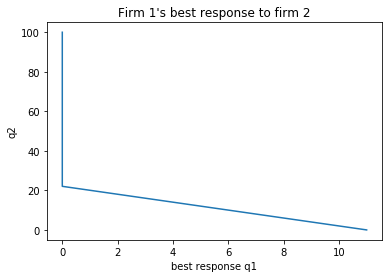

In [15]:
a = 100
b = 4.5
c1 = 1

best_reponse_plot(a, b, c1)

In [10]:
def analytical_BR(q2, c1, a, b):
    BR=max((a-b*q2-c1)/(2*b), 0)
    return BR


In [17]:
def best_reponse_plot_Analytical(a, b, c1):
    range_q2 = arange(0, a, 0.01)
    range_q1 = [analytical_BR(q2, c1, a, b) for q2 in range_q2]
    
    plt.plot(range_q1, range_q2)
    plt.xlabel("best response q1")
    plt.ylabel('q2')
    plt.title("Firm 1's best response to firm 2 - analytical")

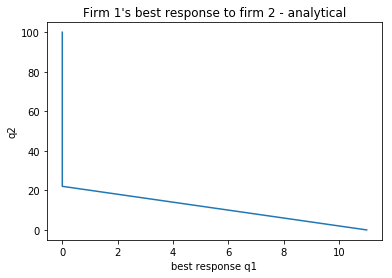

In [18]:
best_reponse_plot_Analytical(a, b, c1)

Equilibrium production:

In [20]:
def help_br(q, c, a, b): #defining a help function that finds where the Best response functions - q are equal to 0 (i.e. fixed points)
    return [q[0]-best_response(q[1], c[0], a, b),q[1]-best_response(q[0], c[1], a, b)]



In [26]:
initial_guess = [0,0]
c = [10,4]

def production_eq(c, initial_guess, a, b): #Equilibrium function which takes in 
    Q = optimize.fsolve(lambda q: help_br(q, c, a, b), initial_guess)
    return Q

In [29]:
production_eq(c, initial_guess, a, b)

array([6.22222222, 7.55555556])

Define a function that outputs summary for given parameters: price, individual q, Q, profits

In [66]:
def summary(c, a, b, initial_guess):
    q1,q2 = production_eq(c, initial_guess, a, b) #Equilibrium productions   
     
    output = print('Industry output is ' + str(q1+q2) + ' with firm 1 producing ' + str(q1) + ' units and firm 2 producing ' + str(q2) + ' units.' + 
                   '\n The equilibrium price per unit becomes ' + str(price(q1, q2, a, b)) )
    return output

In [67]:
summary(c, a, b, initial_guess)

Industry output is 13.77777777777775 with firm 1 producing 6.222222222222209 units and firm 2 producing 7.55555555555554 units.
 The equilibrium price per unit becomes 38.00000000000013
